In [20]:
# -*- coding: utf-8 -*-
# 美吉姆股票走势预测
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar


In [21]:
# 数据加载
df = pd.read_csv('./002621.csv')
df = df[['date', 'price']]
print(df)

            date  price
0     2020-10-16   7.07
1     2020-10-15   7.04
2     2020-10-14   6.85
3     2020-10-13   6.95
4     2020-10-12   6.96
...          ...    ...
2192  2011-10-11  24.13
2193  2011-10-10  23.60
2194  2011-09-30  22.69
2195  2011-09-29  24.08
2196  2011-09-20   0.00

[2197 rows x 2 columns]


In [22]:
#将时间作为索引,方便后面对时间的运算
df.index = pd.to_datetime(df.date)
print(df.head())

                  date  price
date                         
2020-10-16  2020-10-16   7.07
2020-10-15  2020-10-15   7.04
2020-10-14  2020-10-14   6.85
2020-10-13  2020-10-13   6.95
2020-10-12  2020-10-12   6.96


In [23]:
df_month = df.resample('M').mean()#由于并非每天都有数据，这里采用按月统计
print(df_month)

                price
date                 
2011-09-30  15.590000
2011-10-31  25.367500
2011-11-30  26.827727
2011-12-31  22.894545
2012-01-31  20.243333
...               ...
2020-06-30   7.218500
2020-07-31   7.094783
2020-08-31   7.286190
2020-09-30   6.739091
2020-10-31   6.955000

[110 rows x 1 columns]


In [24]:
# 设置参数范围，利用product函数将三个参数进行笛卡尔积，进行暴力寻参
ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)

In [26]:
#暴力寻参，利用打擂法，寻找aic最小的model
best_aic = float("inf") # 先初始化aic，因为要找最小aic，所以这里初始化最大值为无穷
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(df_month.price,
                                order=(param[0], param[1], param[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:#打擂法，如果更小则保留
        best_model = model
        best_aic = aic
        best_param = param
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                             Statespace Model Results                           
Dep. Variable:                  price   No. Observations:                  110
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -309.254
Date:                Tue, 20 Oct 2020   AIC                            630.507
Time:                        00:16:41   BIC                            646.373
Sample:                    09-30-2011   HQIC                           636.935
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6442      0.197      3.269      0.001       0.258       1.030
ma.L1         -0.9612    199.956     -0.005      0.996    -392.867     390.945
ma.L2         -0.0067      7.846     -0.001  

In [34]:
# 计算出接下来需要预测的三个月时间
future_month = 3
last_month = pd.to_datetime(df_month.index[len(df_month2)-1])
print(last_month)

date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:#如果是12月，下个月为1月
        month = 1
        year = year+1#年份+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

2020-10-31 00:00:00
date_list= [Timestamp('2020-11-30 00:00:00', freq='M'), Timestamp('2020-12-31 00:00:00', freq='M'), Timestamp('2021-01-31 00:00:00', freq='M')]


In [35]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)#创建df，索引为计算出的接下来3个月的时间，列为源数据相同列
print(future)
df_month2 = pd.concat([df_month2, future])#将两段数据进行拼接，相当于sql中的union all

           price
2020-11-30   NaN
2020-12-31   NaN
2021-01-31   NaN


                price   forecast
2011-09-30  15.590000   0.000000
2011-10-31  25.367500  20.611477
2011-11-30  26.827727  31.666006
2011-12-31  22.894545  27.768493
2012-01-31  20.243333  20.360932
...               ...        ...
2020-09-30   6.739091   9.219886
2020-10-31   6.955000   8.942839
2020-11-30        NaN   9.082586
2020-12-31        NaN  10.498331
2021-01-31        NaN  11.512299

[113 rows x 2 columns]


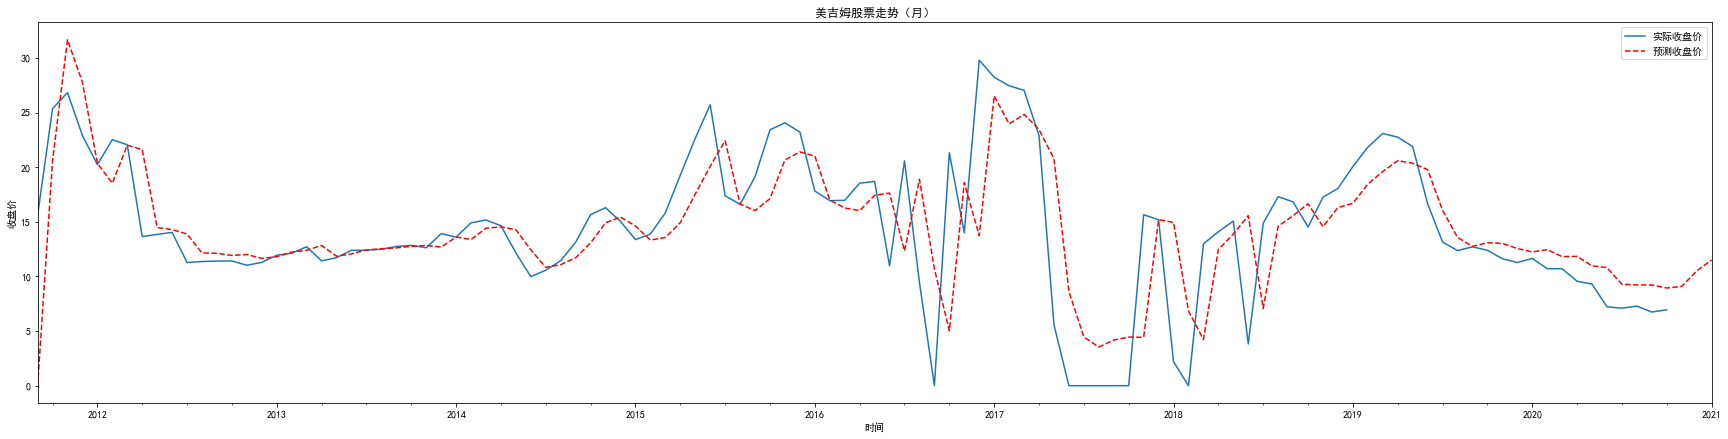

In [41]:
# get_prediction得到的是区间，使用predicted_mean求得平均数作为点值
df_month2['forecast'] = best_model.get_prediction(start=0, end=len(df_month2)).predicted_mean
print(df_month2)
# 美吉姆股票走势结果显示
plt.figure(figsize=(30,7))
df_month2.price.plot(label='实际收盘价')
df_month2.forecast.plot(color='r', ls='--', label='预测收盘价')
plt.legend()
plt.title('美吉姆股票走势（月）')
plt.xlabel('时间')
plt.ylabel('收盘价')
plt.show()
